In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as pycaps_radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
import pyart
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar and disdrometer data.
sys.path.append('/Users/dawson29/Projects/pyPIPS/configs/')

from PERiLS_IOP2_2022_officeMac import *

In [9]:
radar_dir = radar_config_dict['radar_dir']
radfile_name = 'KGWX20220331_021011_V06.nc'
radpath = os.path.join(radar_dir, radfile_name)

radar_obj = pyart.io.read_cfradial(radpath)

In [22]:
radar_dir2 = '/Users/dawson29/sshfs_mounts/depot/data/Projects/PERiLS/obsdata/2022/NEXRAD/Radx'
radfile_name2 = 'cfrad.20220331_021011.524_to_20220331_021703.249_KGWX_SUR.nc'
radpath2 = os.path.join(radar_dir2, radfile_name2)

radar_obj2 = pyart.io.read_cfradial(radpath2)

In [10]:
print(radar_obj.info())

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	units: meters
	standard_name: Altitude
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (12600,)>
	long_name: azimuth_angle_from_true_north
	units: degrees
	standard_name: beam_azimuth_angle
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (12600,)>
	long_name: elevation_angle_from_horizontal_plane
	units: degrees
	standard_name: beam_elevation_angle
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	differential_reflectivity:
		data: <ndarray of type: float32 and shape: (12600, 1832)>
		_FillValue: -9999.0
		long_name: log_differential_reflectivity_hv
		units: dB
		standard_name: log_differential_reflectivity_hv
		valid_max: 7.9375
		valid_min: -7.875
		coordinates: elevation azimuth range
	spectru

In [23]:
print(radar_obj2.info())

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude
	units: meters
	_FillValue: -9999.0
	positive: up
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude_above_ground_level
	units: meters
	_FillValue: -9999.0
	positive: up
antenna_transition:
	data: <ndarray of type: int8 and shape: (8280,)>
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	_FillValue: -128
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (8280,)>
	long_name: ray_azimuth_angle
	units: degrees
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (8280,)>
	long_name: ray_elevation_angle
	units: degrees
	_FillValue: -9999.0
	positive: up
fields:
	REF:
		data: <ndarray of type: float32 and shape: (8280, 1832)>
		long_name: radar_reflectivity
		standard_name: equivalent_reflectivity_factor
		units: dBZ
		sampling_ratio: 1.0
		_FillValue: -128
		grid_mapping: grid_mapping
	

In [24]:
target_elevs = radar_obj.fixed_angle['data']
times = radar_obj.time['data']
target_elevs2 = radar_obj2.fixed_angle['data']
times2 = radar_obj2.time['data']
print(target_elevs)
print(target_elevs2)

[ 0.48339844  0.48339844  0.87890625  0.87890625  0.48339844  0.48339844
  1.3183594   1.3183594   1.8017578   0.48339844  0.48339844  2.4169922
  3.1201172   3.9990234   5.0976562   6.4160156   0.48339844  0.48339844
  7.998047   10.019531   12.480469   15.600586   19.511719  ]
[ 0.48339844  0.87890625  0.48339844  1.3183594   1.8017578   0.48339844
  2.4169922   3.1201172   3.9990234   5.0976562   6.4160156   0.48339844
  7.998047   10.019531   12.480469   15.600586   19.511719  ]


In [85]:
el_req = 0.5
firstsweepindex = (np.abs(target_elevs - el_req)).argmin()
el_actual = target_elevs[firstsweepindex]
print(firstsweepindex, el_actual)
sweep_indices = [i for i, x in enumerate(target_elevs) if x == el_actual]
print(sweep_indices)
print(radar_obj.sweep_start_ray_index['data'][sweep_indices])


0 0.48339844
[0, 1, 4, 5, 9, 10, 16, 17]
[    0   720  2880  3600  6120  6840  9360 10080]


In [25]:
print(radar_obj.instrument_parameters)
print(radar_obj2.instrument_parameters)

{'nyquist_velocity': {'long_name': 'Nyquist velocity', 'units': 'meters_per_second', 'comments': 'Unambiguous velocity', 'meta_group': 'instrument_parameters', 'data': masked_array(data=[ 8.37,  8.37,  8.37, ..., 33.44, 33.44, 33.44],
             mask=False,
       fill_value=1e+20,
            dtype=float32)}, 'unambiguous_range': {'long_name': 'Unambiguous range', 'units': 'meters', 'comments': 'Unambiguous range', 'meta_group': 'instrument_parameters', 'data': masked_array(data=[467000., 467000., 467000., ..., 117000., 117000.,
                   117000.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)}}
{'follow_mode': {'long_name': 'follow_mode_for_scan_strategy', 'options': 'none, sun, vehicle, aircraft, target, manual', 'meta_group': 'instrument_parameters', 'data': masked_array(
  data=[[b'n', b'o', b'n', b'e', --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --],
       

In [62]:
radar_sweep_start_indices = radar_obj.sweep_start_ray_index['data']
radar2_sweep_start_indices = radar_obj2.sweep_start_ray_index['data']

print(radar_obj.sweep_start_ray_index)
sweep_numbers = radar_obj.sweep_number['data']
print(sweep_numbers)
sweep_times = []
sweep_times_sec = []
for i, sweep_num in enumerate(sweep_numbers):
    sweep_time_sec = int(radar_obj.time['data'][radar_sweep_start_indices[i]])
    sweep_times_sec.append(sweep_time_sec)
    sweep_time = pyart.graph.common.generate_radar_time_sweep(radar_obj, i)
    sweep_times.append(sweep_time)
print(sweep_times)
print(sweep_times_sec)

print(radar_obj2.sweep_start_ray_index)
sweep_numbers2 = radar_obj2.sweep_number['data']
print(sweep_numbers2)
sweep_times2 = []
sweep_times_sec2 = []
for i, sweep_num in enumerate(sweep_numbers2):
    sweep_time_sec2 = int(radar_obj2.time['data'][radar2_sweep_start_indices[i]])
    sweep_times_sec2.append(sweep_time_sec2)
    sweep_time = pyart.graph.common.generate_radar_time_sweep(radar_obj2, i)
    sweep_times2.append(sweep_time)
print(sweep_times2)
print(sweep_times_sec2)

{'long_name': 'Index of first ray in sweep, 0-based', 'units': 'count', 'data': masked_array(data=[    0,   720,  1440,  2160,  2880,  3600,  4320,  5040,
                    5760,  6120,  6840,  7560,  7920,  8280,  8640,  9000,
                    9360, 10080, 10800, 11160, 11520, 11880, 12240],
             mask=False,
       fill_value=999999,
            dtype=int32)}
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[datetime.datetime(2022, 3, 31, 2, 10, 11), datetime.datetime(2022, 3, 31, 2, 10, 29), datetime.datetime(2022, 3, 31, 2, 10, 54), datetime.datetime(2022, 3, 31, 2, 11, 12), datetime.datetime(2022, 3, 31, 2, 11, 38), datetime.datetime(2022, 3, 31, 2, 11, 55), datetime.datetime(2022, 3, 31, 2, 12, 21), datetime.datetime(2022, 3, 31, 2, 12, 38), datetime.datetime(2022, 3, 31, 2, 13, 4), datetime.datetime(2022, 3, 31, 2, 13, 18), datetime.datetime(2022, 3, 31, 2, 13, 36), datetime.datetime(2022, 3, 31, 2, 14, 2), datetime.datetime(2022, 3, 31, 2, 14, 

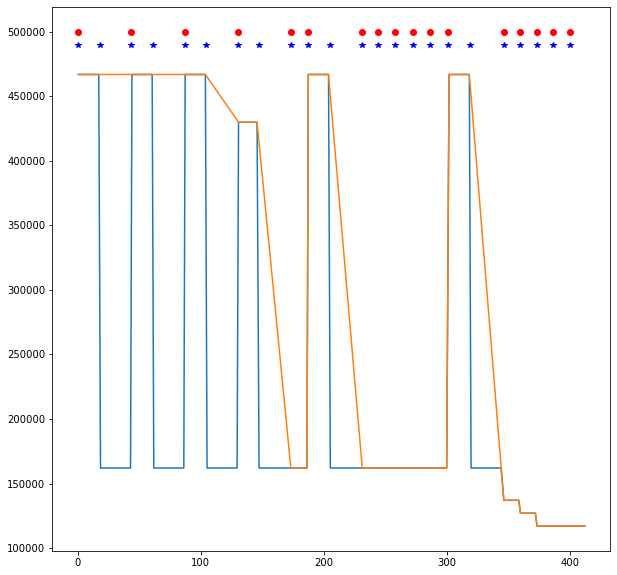

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sweep_times_sec, [490000.] * len(sweep_times_sec), 'b*')
ax.plot(sweep_times_sec2, [500000.] * len(sweep_times_sec2), 'ro')
ax.plot(times, radar_obj.instrument_parameters['unambiguous_range']['data'])
ax.plot(times2, radar_obj2.instrument_parameters['unambiguous_range']['data'])

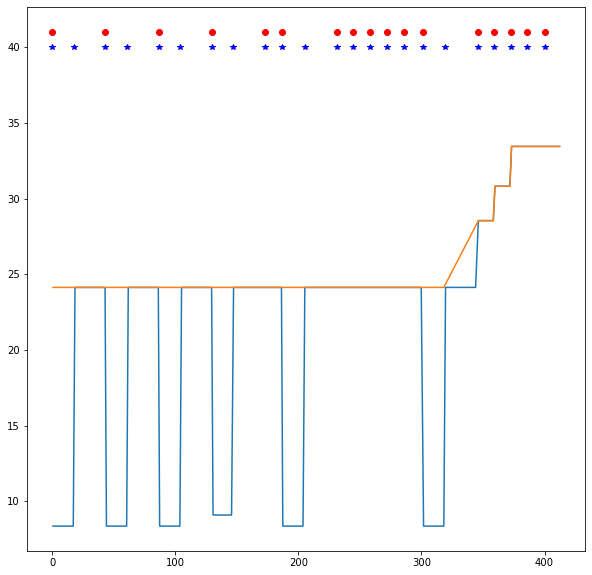

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sweep_times_sec, [40.] * len(sweep_times_sec), 'b*')
ax.plot(sweep_times_sec2, [41.] * len(sweep_times_sec2), 'ro')
ax.plot(times, radar_obj.instrument_parameters['nyquist_velocity']['data'])
ax.plot(times2, radar_obj2.instrument_parameters['nyquist_velocity']['data'])

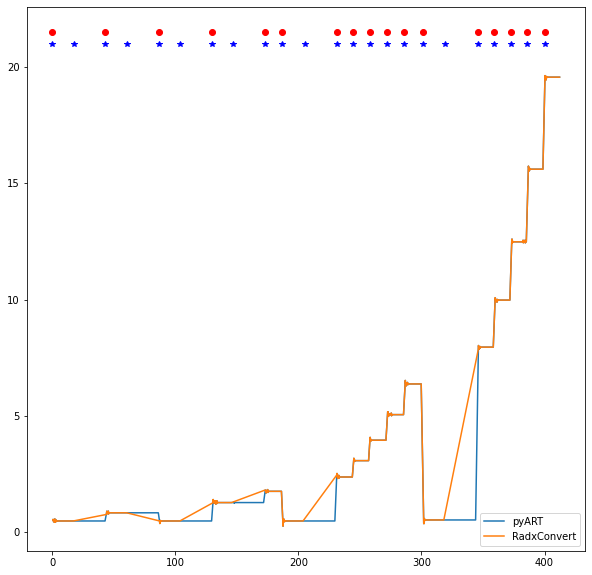

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sweep_times_sec, [21.] * len(sweep_times_sec), 'b*')
ax.plot(sweep_times_sec2, [21.5] * len(sweep_times_sec2), 'ro')
elevs = radar_obj.elevation['data']
elevs2 = radar_obj2.elevation['data']
ax.plot(times, elevs, label='pyART')
ax.plot(times2, elevs2, label='RadxConvert')
ax.legend(loc='best')

In [42]:
sweep_numbers = radar_obj.sweep_number['data']
sweep_list = []
for i, sweep_num in enumerate(sweep_numbers):
    sweep = radar_obj.extract_sweeps([i])
    sweep_list.append(sweep)
    
sweep_numbers2 = radar_obj2.sweep_number['data']
sweep_list2 = []
for i, sweep_num in enumerate(sweep_numbers2):
    sweep = radar_obj2.extract_sweeps([i])
    sweep_list2.append(sweep)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


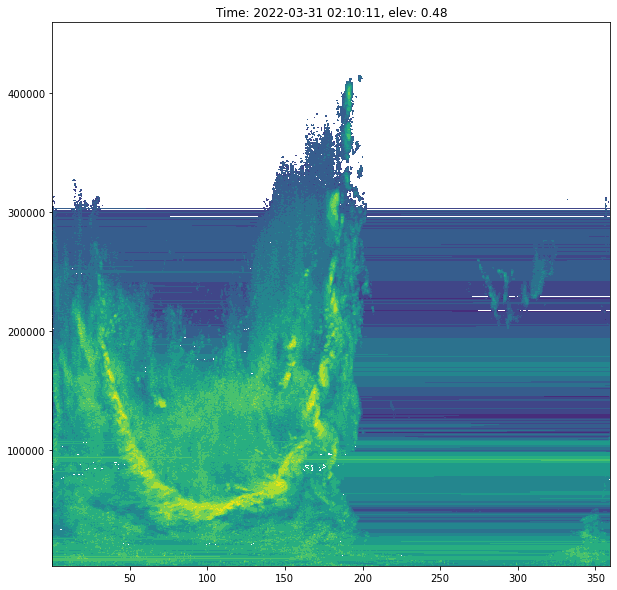

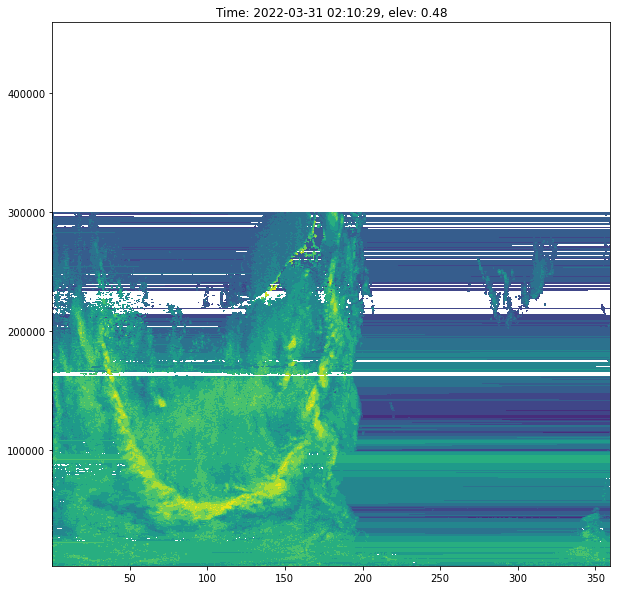

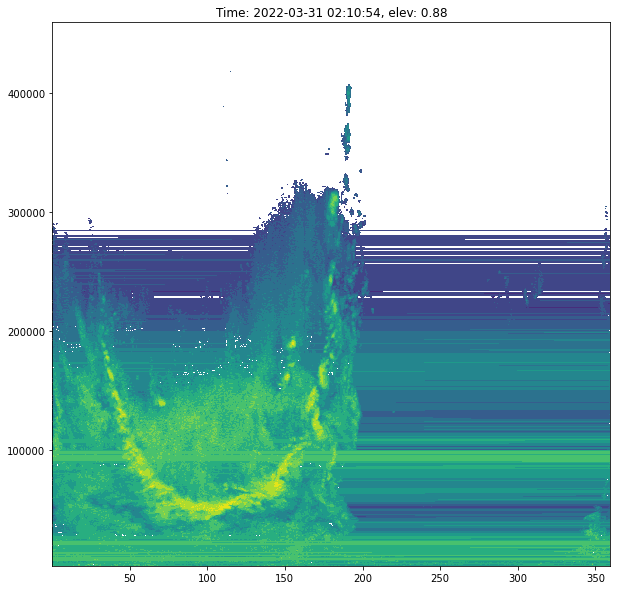

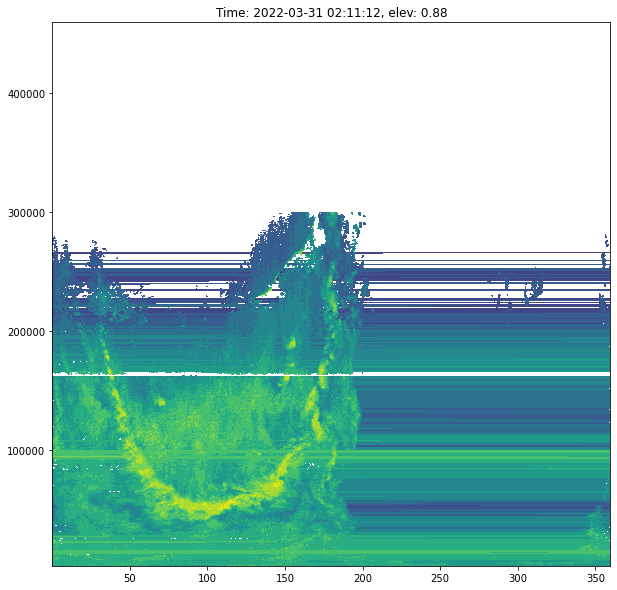

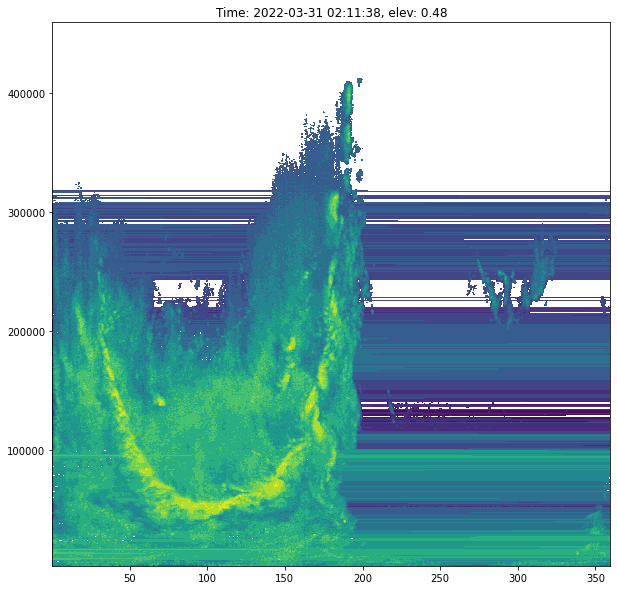

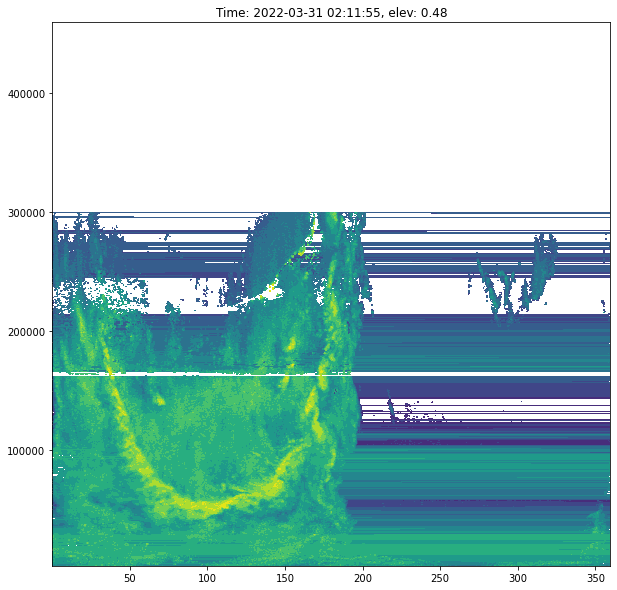

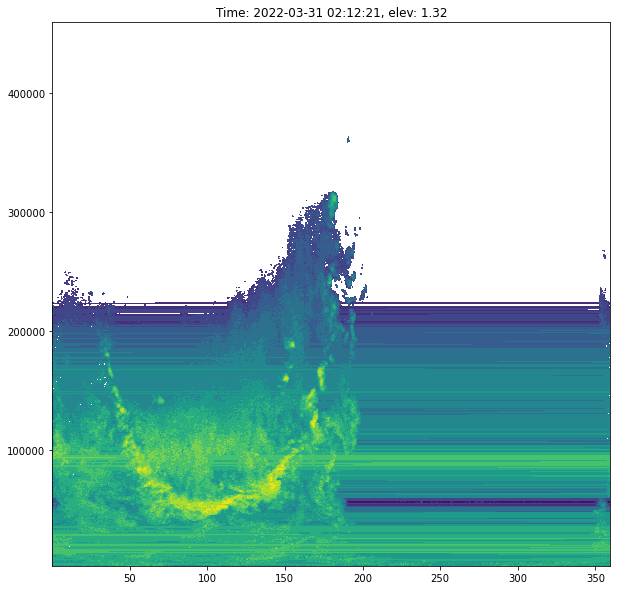

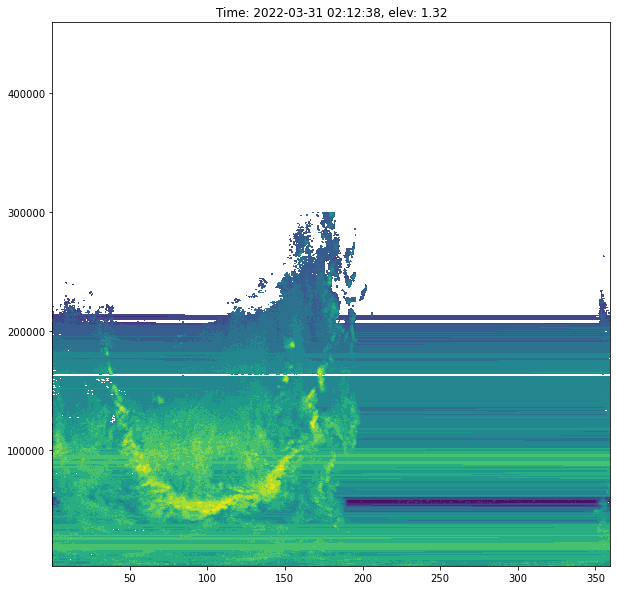

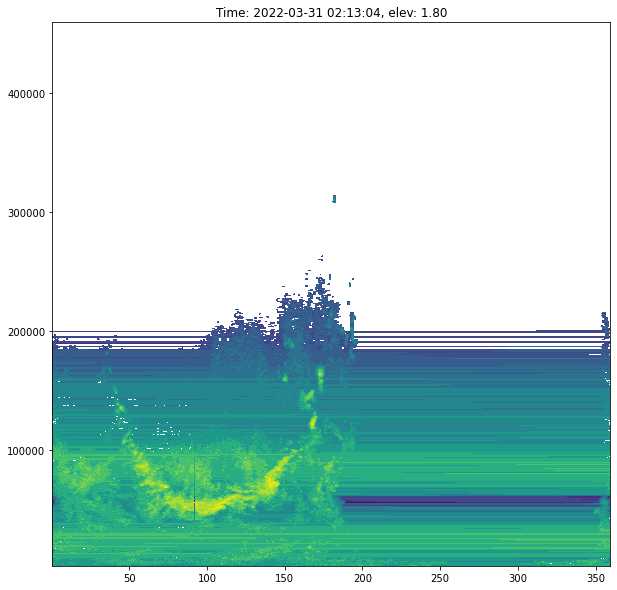

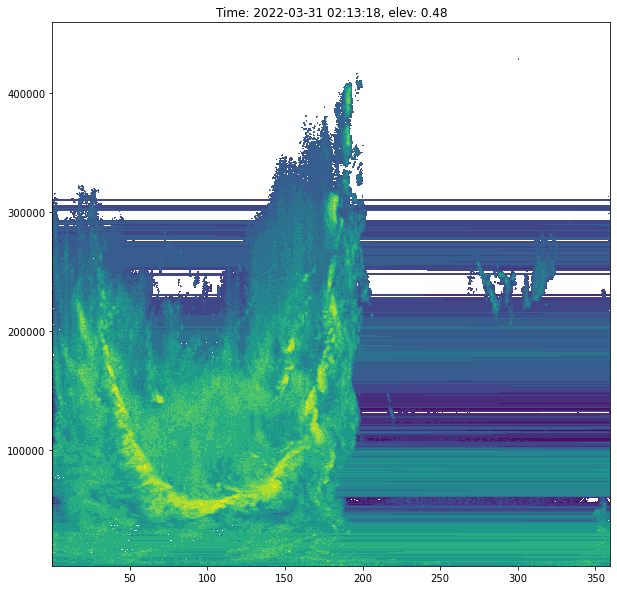

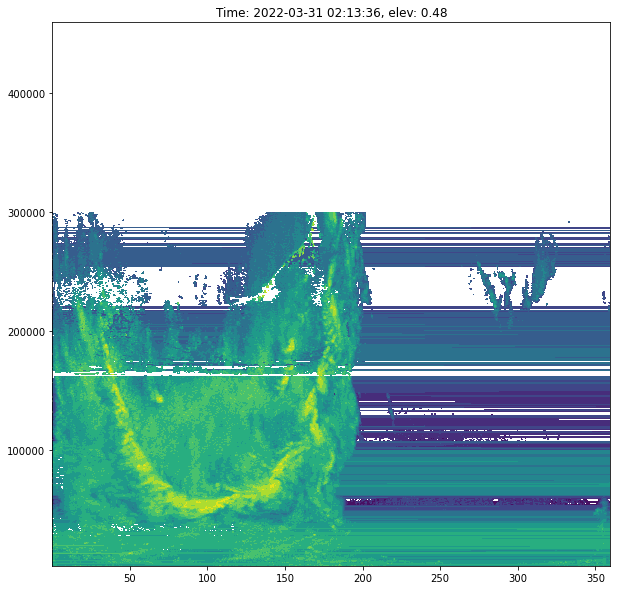

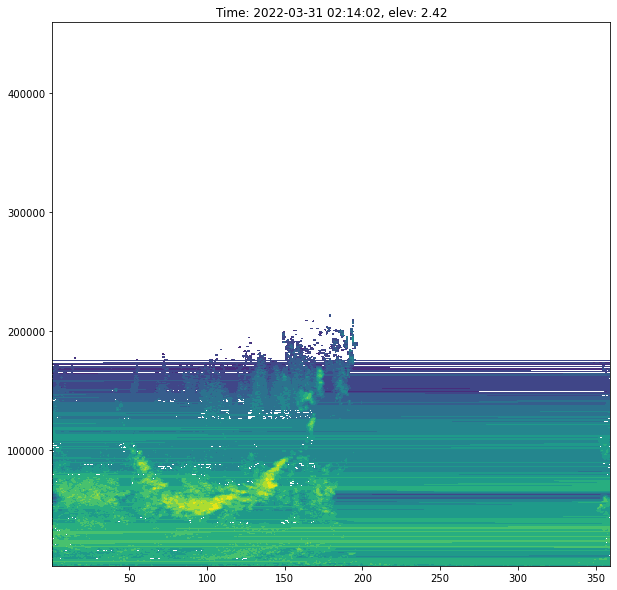

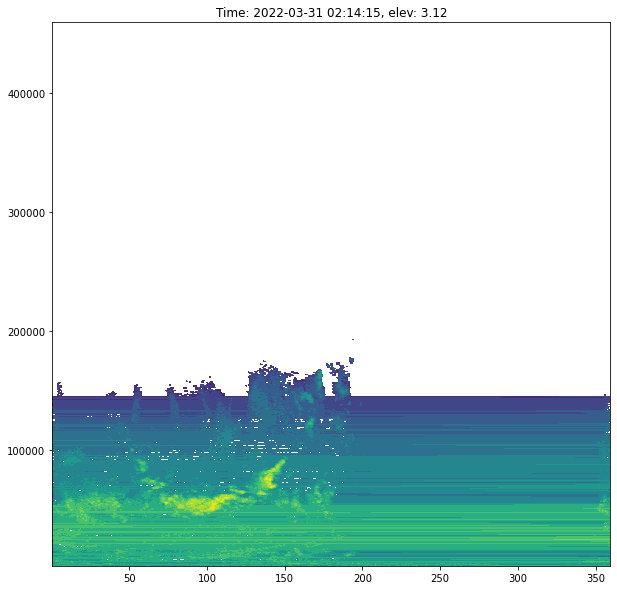

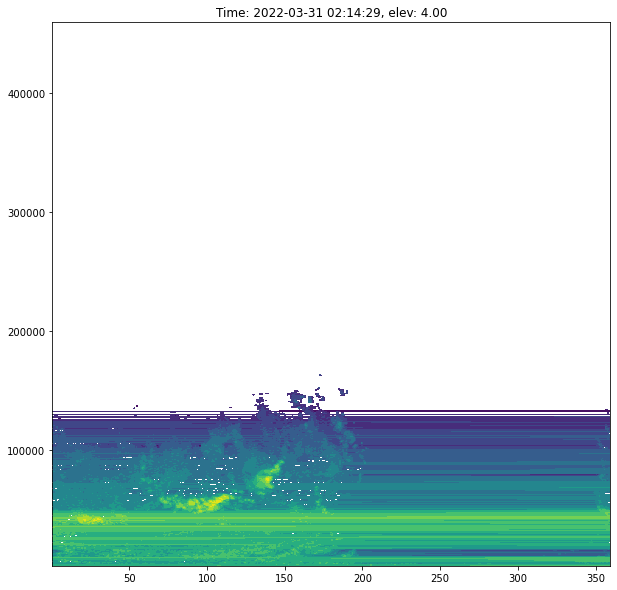

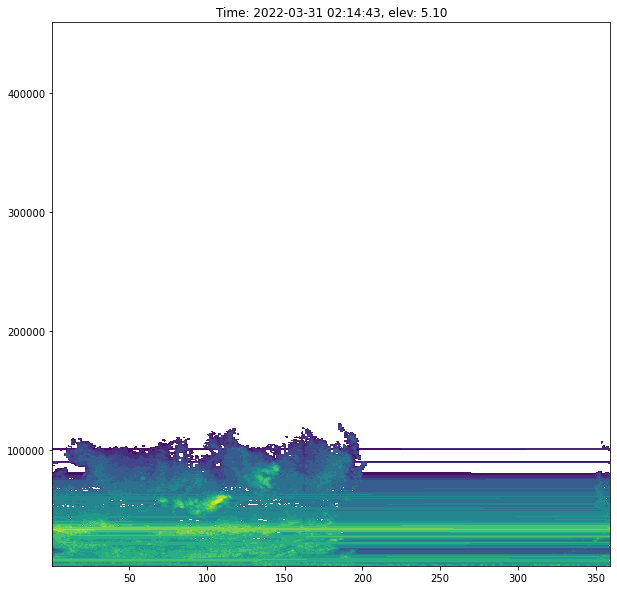

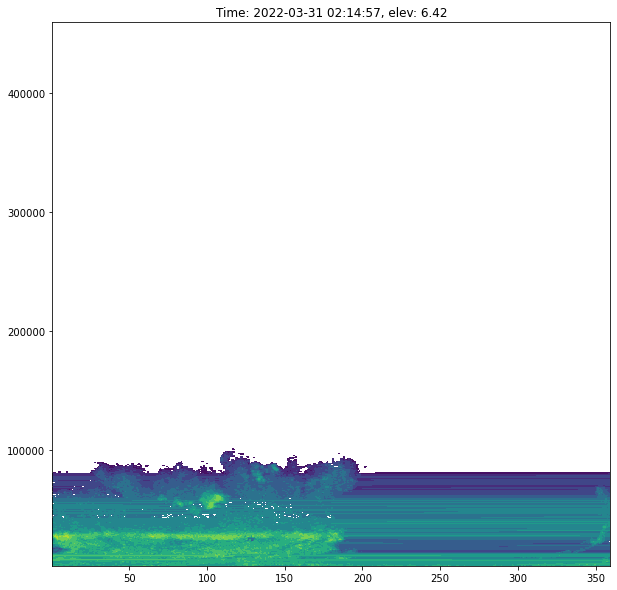

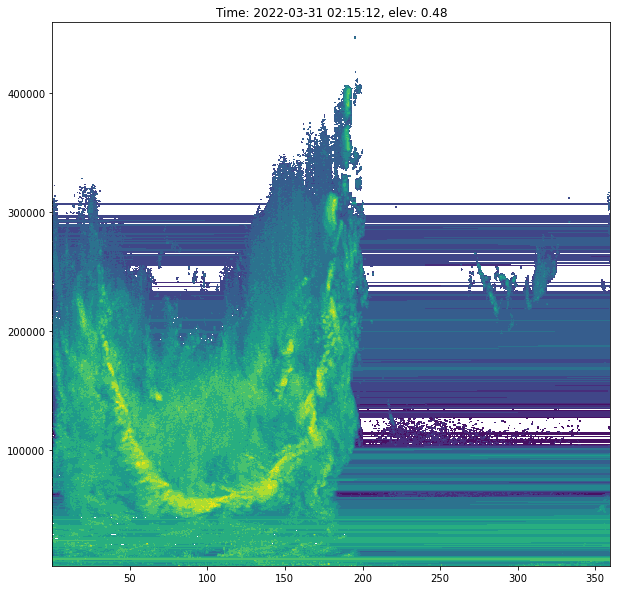

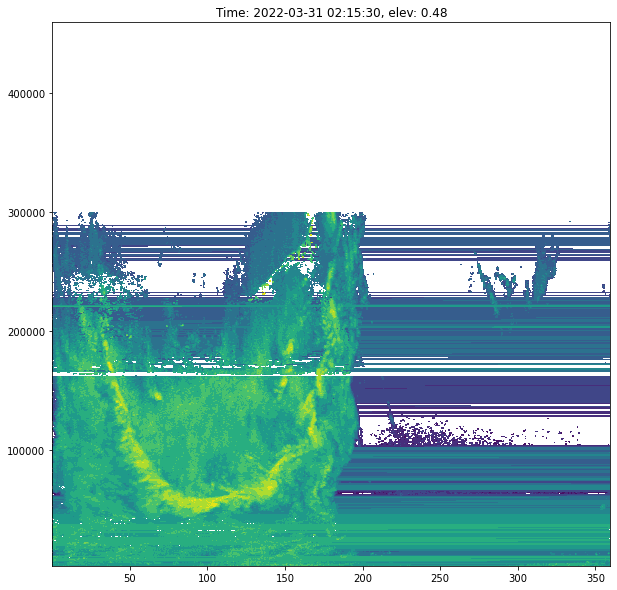

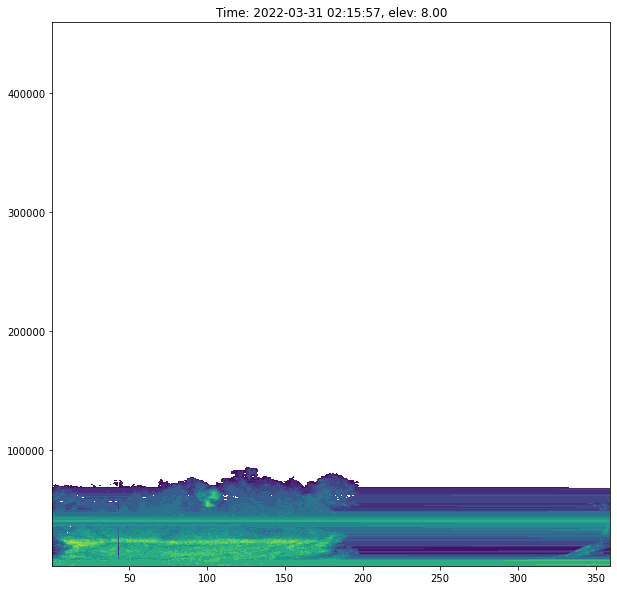

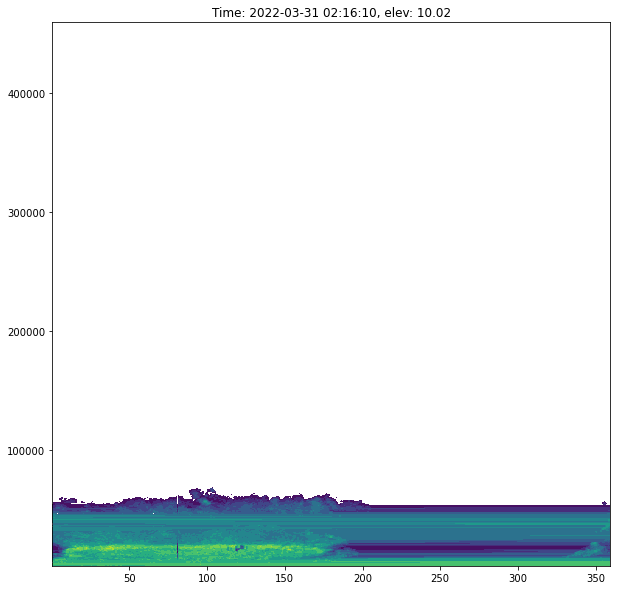

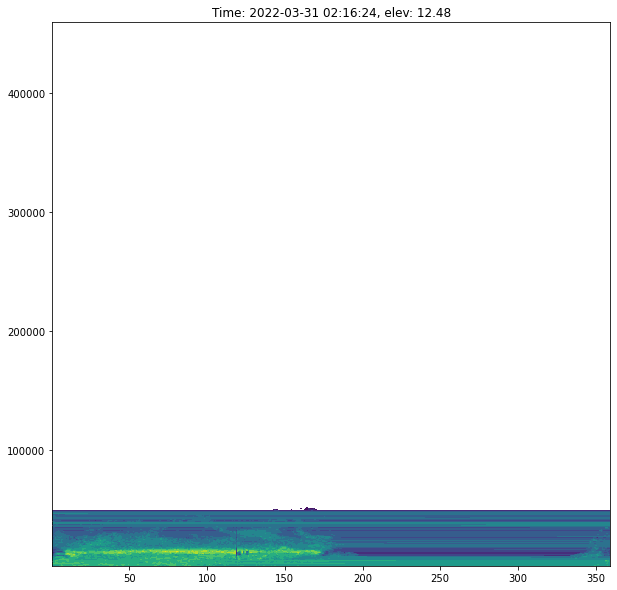

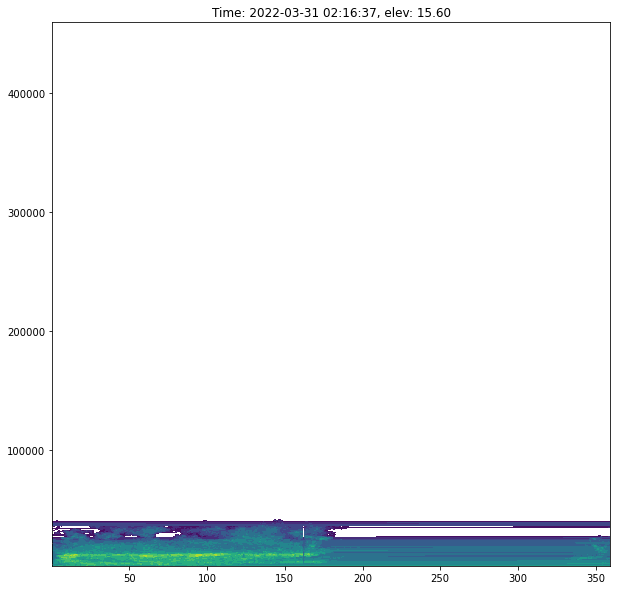

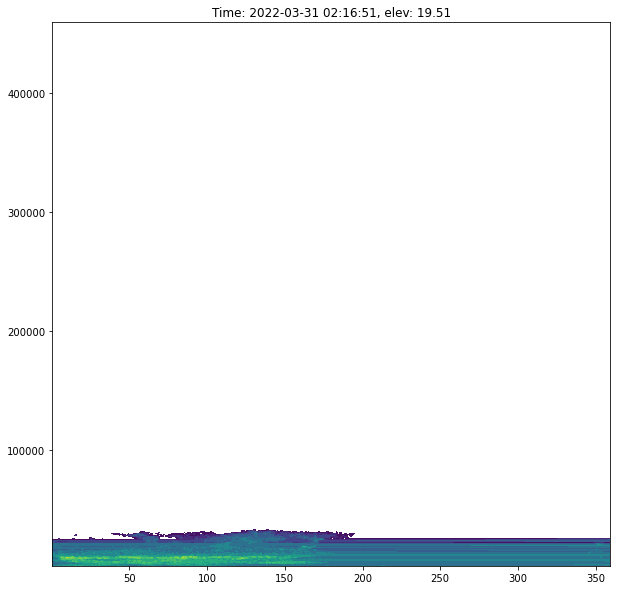

In [76]:
field = 'reflectivity'
levels = np.linspace(0., 60., num=13)
for i, sweep_num in enumerate(sweep_numbers):
    fig, ax = plt.subplots(figsize=(10, 10))
    data = sweep_list[i].fields[field]['data']
    azimuth = sweep_list[i].azimuth['data']
    grange = sweep_list[i].range['data']
    ax.set_title('Time: {}, elev: {:.2f}'.format(sweep_times[i].strftime('%Y-%m-%d %H:%M:%S'), target_elevs[i]))
    ax.contourf(azimuth, grange, data.T, levels=levels)

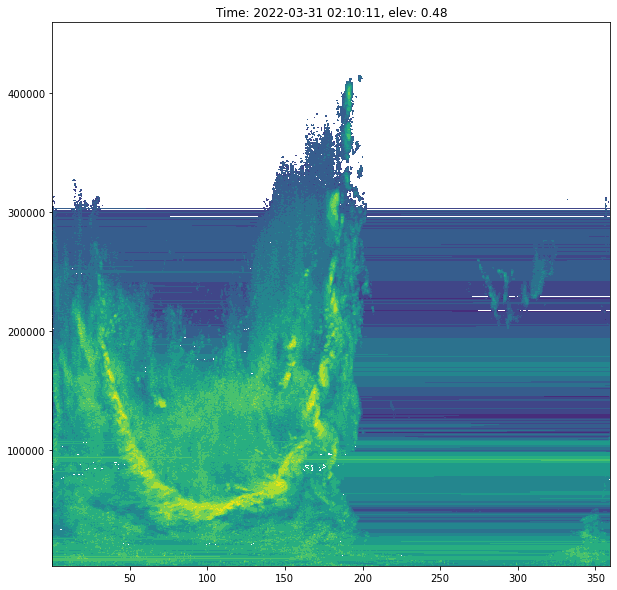

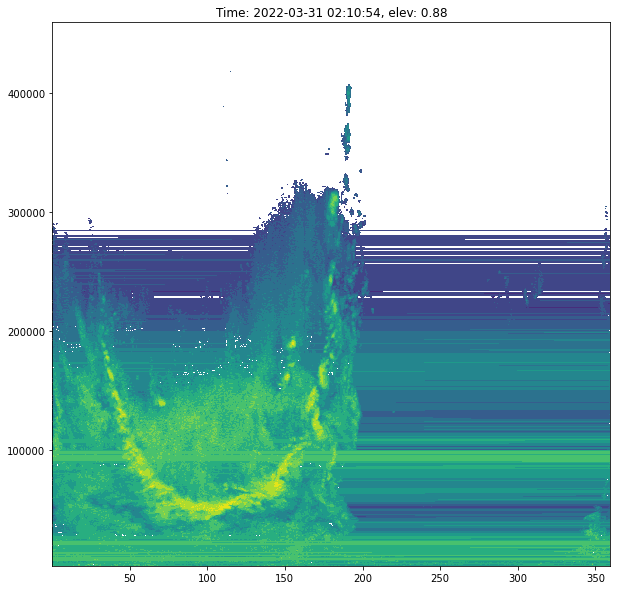

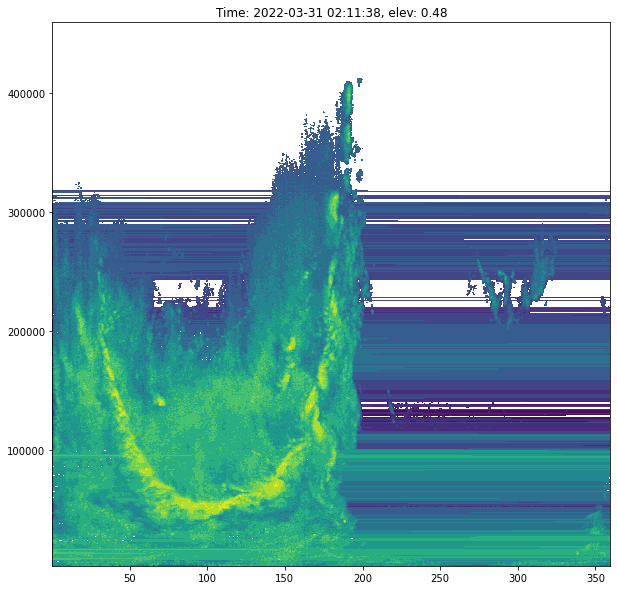

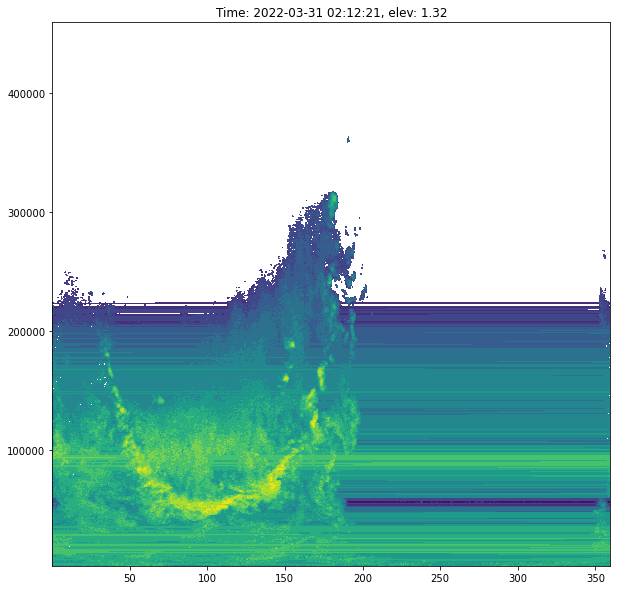

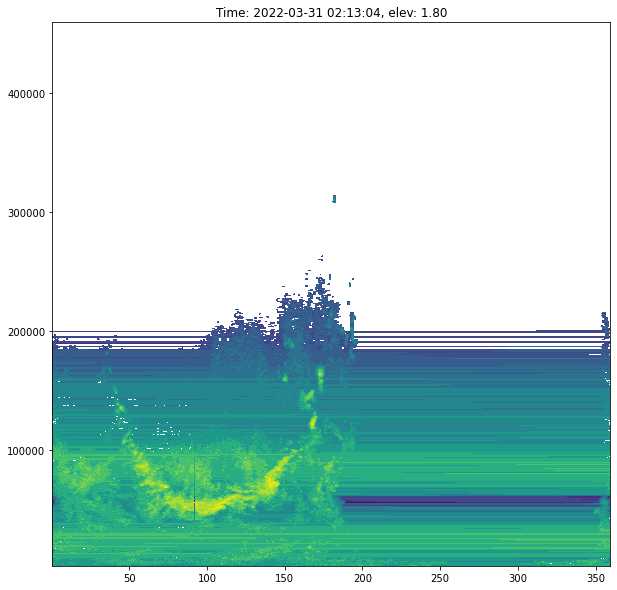

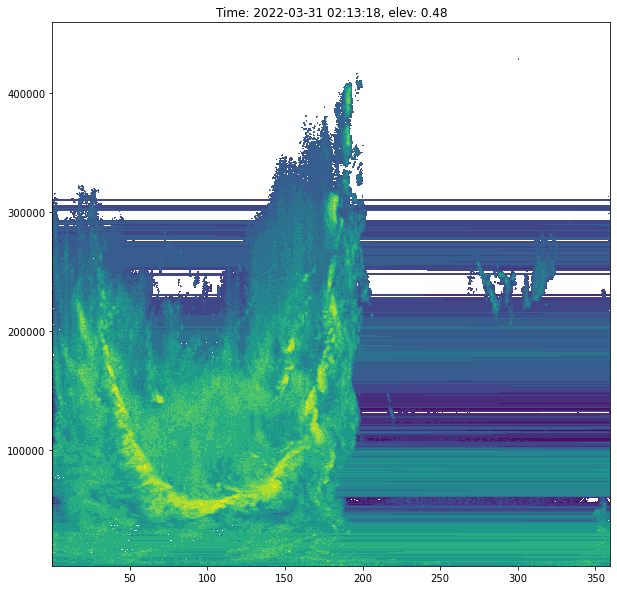

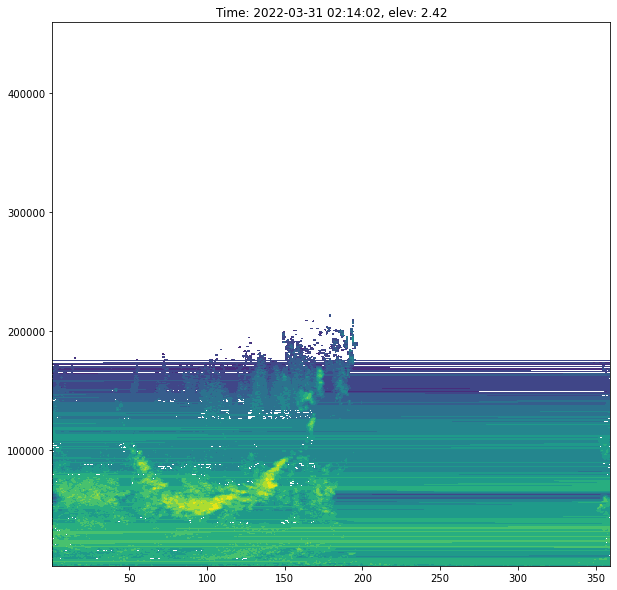

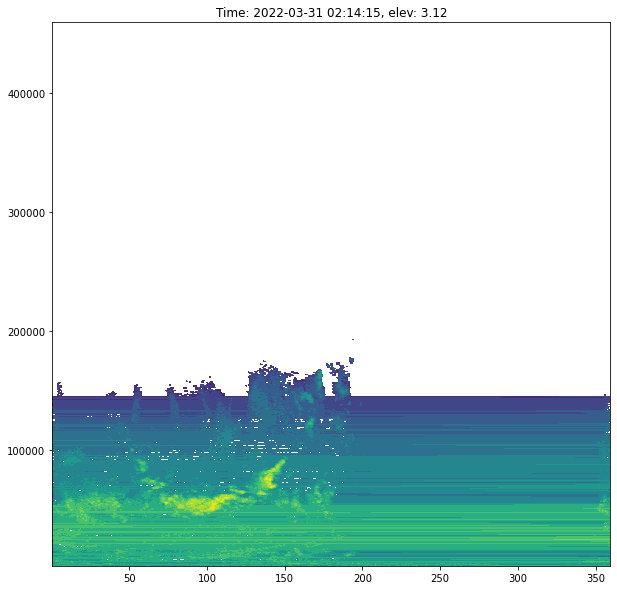

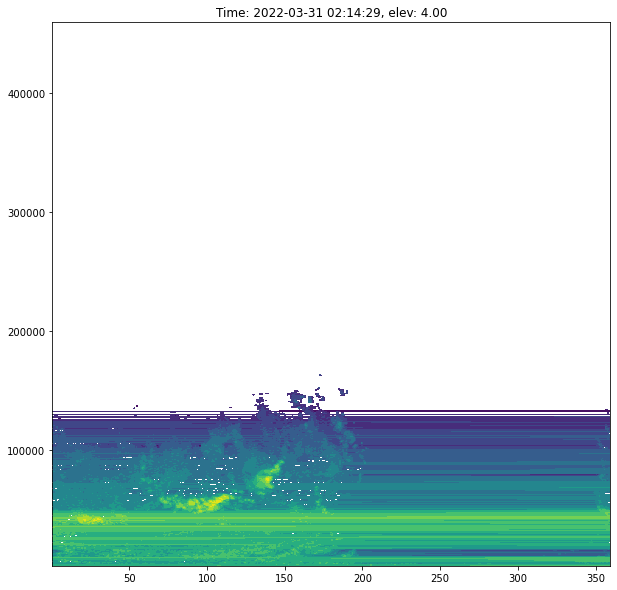

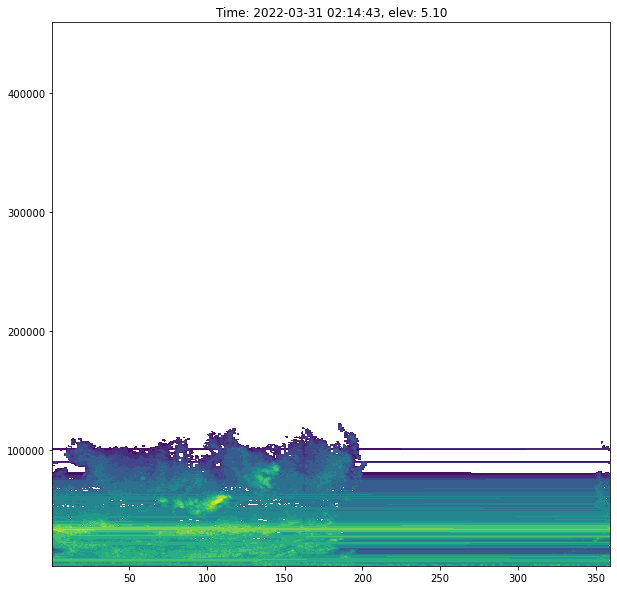

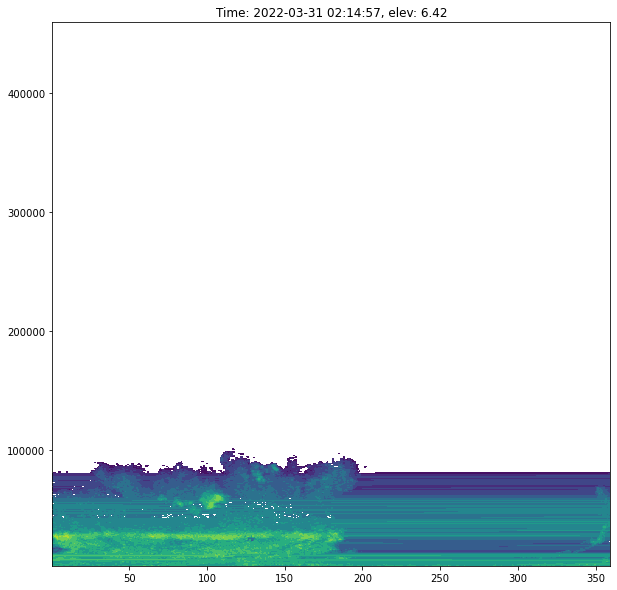

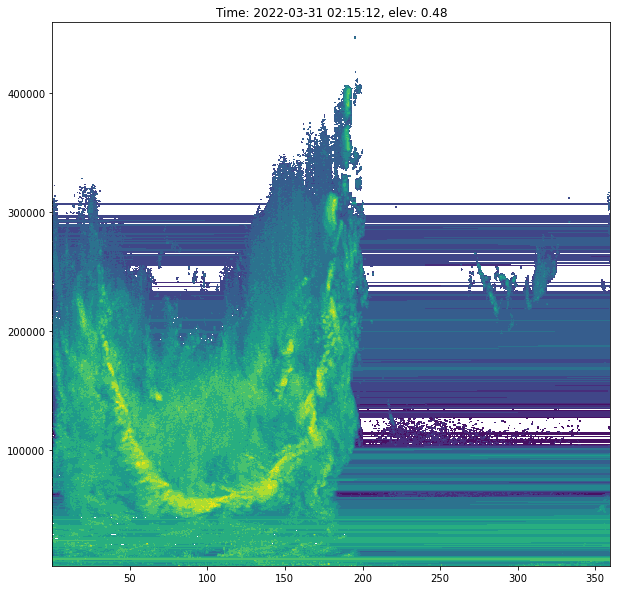

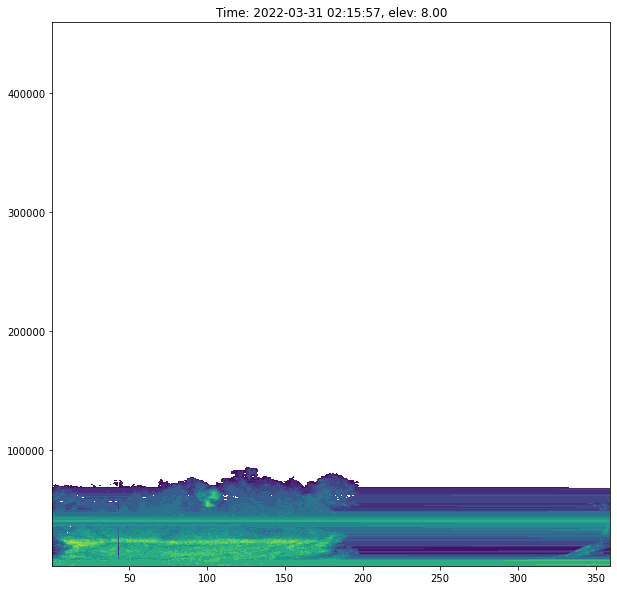

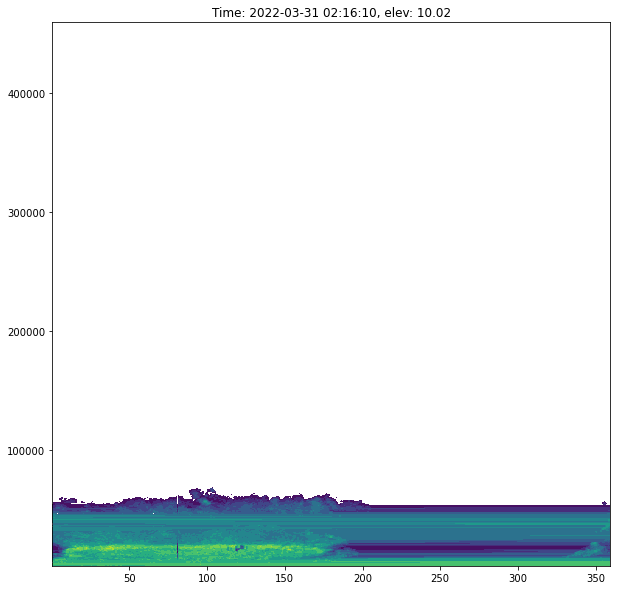

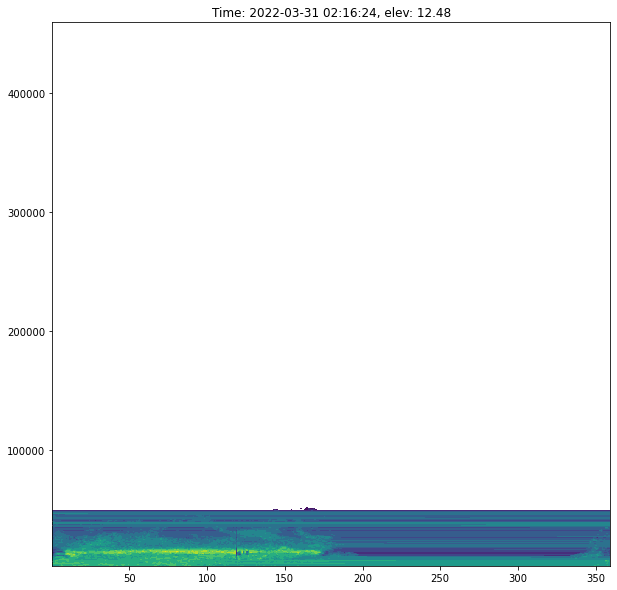

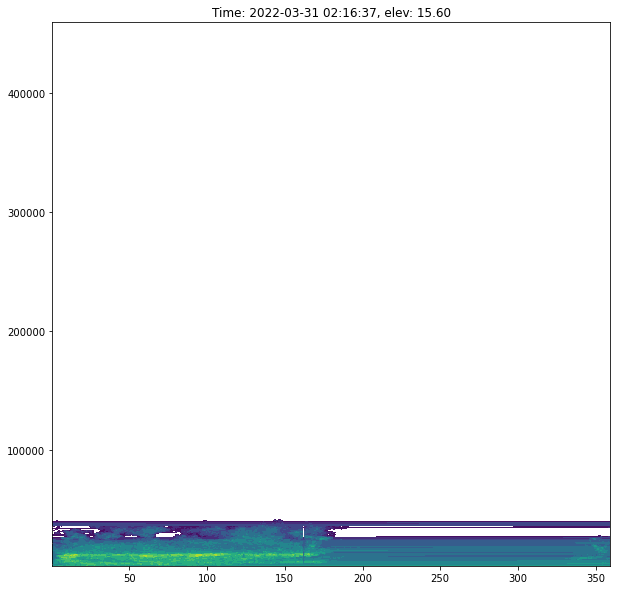

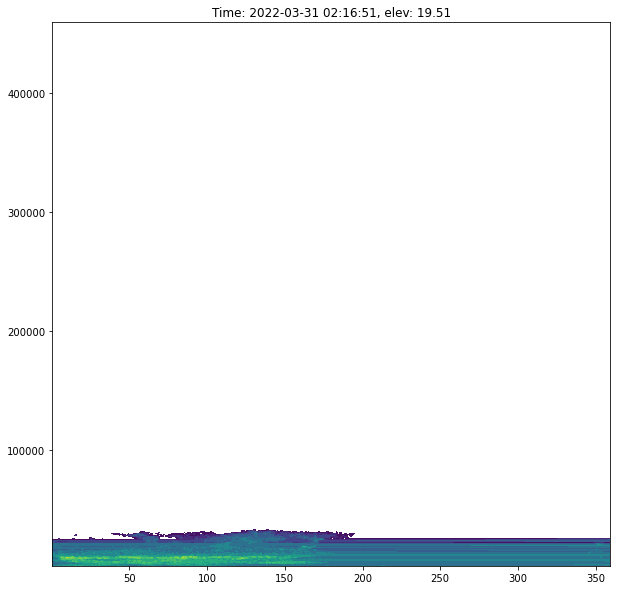

In [77]:
field = 'REF'
levels = np.linspace(0., 60., num=13)
for i, sweep_num in enumerate(sweep_numbers2):
    fig, ax = plt.subplots(figsize=(10, 10))
    data = sweep_list2[i].fields[field]['data']
    azimuth = sweep_list2[i].azimuth['data']
    grange = sweep_list2[i].range['data']
    ax.set_title('Time: {}, elev: {:.2f}'.format(sweep_times2[i].strftime('%Y-%m-%d %H:%M:%S'), target_elevs2[i]))
    ax.contourf(azimuth, grange, data.T, levels=levels)

In [ ]:
# Read in the PIPS data for the first probe for testing
dis_dict = init_dis_dict[casedate]
dirname = dis_dict['dis_dir']
filename = dis_dict['disfilenames'][0]
filepath = os.path.join(dirname, filename)
print("Reading file: {}".format(filepath))
conv_df, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)

In [ ]:
# Read sweep files
radar_name = init_radar_dict[casedate]['radname']
radar_dir = init_radar_dict[casedate]['radardir']
starttime = init_radar_dict[casedate]['radstarttimestamp']
stoptime = init_radar_dict[casedate]['radstoptimestamp']
field_names = init_radar_dict[casedate]['fieldnames']
el_req = init_radar_dict[casedate]['el_req']

radar_dict = radar.read_sweeps(radar_name, radar_dir, starttime, stoptime, field_names=field_names, 
                               el_req=el_req, compute_kdp=False)

In [ ]:
print(radar_obj.info())

In [ ]:
GPS_stats = conv_df['GPS_status']
GPS_lats = conv_df['GPS_lat']
GPS_lons = conv_df['GPS_lon']
GPS_alts = conv_df['GPS_alt']
PIPS_lat, PIPS_lon, PIPS_alt = pipsio.get_PIPS_loc(GPS_stats, GPS_lats, GPS_lons, GPS_alts)

In [ ]:
PIPS_geo_loc = (PIPS_lat, PIPS_lon)
PIPS_rad_loc = radar.get_PIPS_loc_relative_to_radar(PIPS_geo_loc, radar_obj)

In [ ]:
print(PIPS_rad_loc)

In [ ]:
radar_fields_at_PIPS_da = radar.interp_sweeps_to_PIPS(radar_name, radar_dict['radarsweeplist'], ['PIPS1A'], [PIPS_rad_loc],
                                                      average_gates=True)

In [ ]:
import pyart
radar_obj = radar_dict['radarsweeplist'][2]
xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
distance = np.sqrt((PIPS_rad_loc[0] - xrad)**2. + (PIPS_rad_loc[1] - yrad)**2.)
theta_index, range_index = np.unravel_index(distance.argmin(), distance.shape)

print(theta_index, range_index)

display = pyart.graph.RadarDisplay(radar_obj)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('ZDR', 0, title='NEXRAD Differential Reflectivity',
             vmin=0, vmax=5, colorbar_label='', ax=ax)
display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-250, 250), ylim=(-250, 250))
display.set_limits(xlim=(50, 70), ylim=(120, 140), ax=ax)
ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*')
ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
#ax.contourf(xrad / 1000., yrad / 1000., distance)
#ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [ ]:
print(radar_fields_at_PIPS_da)

In [ ]:
print(radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='REF'))
radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='REF').plot()

In [ ]:
# Test dumping to netCDF file
ncfile_dir = './'
ncfile_name = '{}_{}_{}_fields_at_PIPS.nc'.format(radar_name, starttime, stoptime)
ncfile_path = os.path.join(ncfile_dir, ncfile_name)
radar.dump_radar_fields_at_PIPS_nc(ncfile_path, radar_fields_at_PIPS_da)

In [ ]:
# Now test loading it back in
radar_fields_at_PIPS_ds = xr.open_dataset(ncfile_path)
print(radar_fields_at_PIPS_ds)

In [ ]:
radar_fields_at_PIPS_da_2 = radar_fields_at_PIPS_ds['radar_fields_at_PIPS']
print(radar_fields_at_PIPS_da_2)

In [ ]:
print(radar_fields_at_PIPS_da)

In [ ]:
print(radar_fields_at_PIPS_da_2['PIPS_x'])

In [ ]:
print(radar_fields_at_PIPS_da.fields)

In [ ]:
'RHO' in radar_fields_at_PIPS_da.fields

In [ ]:
radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='RHO').size

In [ ]:
pd.to_datetime(radar_fields_at_PIPS_da['time'].values).to_pydatetime()